This is a simple LSTM test with the goal to train to predict a sine wave using PyTorch.

In [ ]:
# Created by Davide Pasca - 2023/07/25

In [ ]:
# This is specific to Google Colab, so that the notebook runs in the
#  right directory where the data is
import os

def is_colab():
  try:
    import google.colab
    return True
  except ImportError:
    return False

if is_colab():
  repo = 'dpasca-pytorch-examples'
  full_path = f'/content/drive/MyDrive/dev/repos/{repo}'

  if os.getcwd() != full_path:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd {full_path}

  %pwd

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
import subprocess
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    #print(subprocess.check_output(["nvidia-smi"], encoding="utf-8").strip())
    print("Torch CUDA version:", torch.version.cuda)
elif torch.backends.mps.is_available():
    device = "mps"

print("Using device:", device)

Torch CUDA version: 11.8
Using device: cuda


In [ ]:
# Ensure that SAMPLE_SIZE_HOURS is an integer constant
SAMPLE_SIZE_HOURS = int(6)
SAMPLE_SIZE_MINS = 60 * SAMPLE_SIZE_HOURS  # 6 hours

USE_LOG_RETURNS = True
# With log-returns, values tend to be very small
# This is a reasonable scale
NORMALIZE_SCALE = 8.0

TRAIN_DATES = ['2017-01-01', '2022-12-31']
TEST_DATES  = ['2023-01-01', '2023-07-23']

LSTM_INPUT_SIZE = 1  # Only 1 feature (univariate time series data)
#LSTM_SEQUENCE_LENGTH = SAMPLE_SIZE_MINS * 6 // 60
LSTM_SEQUENCE_LENGTH_MINS = 14*24*60 # 14 days
LSTM_SEQUENCE_LENGTH = LSTM_SEQUENCE_LENGTH_MINS // SAMPLE_SIZE_MINS
LSTM_LAYERS_N = 2
# https://www.quora.com/How-should-I-set-the-size-of-hidden-state-vector-in-LSTM-in-keras/answer/Yugandhar-Nanda
LSTM_HIDDEN_SIZE = LSTM_SEQUENCE_LENGTH // 2

print("SAMPLE_SIZE_MINS:", SAMPLE_SIZE_MINS, "(%d hours)" % (SAMPLE_SIZE_MINS / 60))
print("LSTM_SEQUENCE_LENGTH:", LSTM_SEQUENCE_LENGTH, "(%d days)" % (LSTM_SEQUENCE_LENGTH_MINS / 60 / 24))
print("LSTM_HIDDEN_SIZE:", LSTM_HIDDEN_SIZE)

LEARNING_RATE_ADAM = 0.001
LEARNING_RATE_ADAGRAD = 0.01
LEARNING_RATE_RMS_PROP = 0.0001
LEARNING_RATE_SGD = 0.01
LEARNING_RATE_RADAM = 0.001
LEARNING_RATE_ADAMW = 0.0025

# L2 regularization
L2_WEIGHT_DECAY = 0*0.0001

# L1 regularization
L1_REG_LAMBDA = 0.000005

# Dropout probability (0 = no dropout)
# This randomly resets some neurons
DROPOUT_P = 0.0 # 0.05 # 0.1

EPOCHS_N = 50000

SAMPLE_SIZE_MINS: 360 (6 hours)
LSTM_SEQUENCE_LENGTH: 56 (14 days)
LSTM_HIDDEN_SIZE: 28


In [ ]:
def normalizeVal(val):
    return val * NORMALIZE_SCALE

def denormalizeVal(val):
    return val / NORMALIZE_SCALE

def safeLog(vals: torch.Tensor) -> torch.Tensor:
    return torch.where(vals > 0, torch.log(vals), torch.tensor(0.0))

def make_input_data(vals: torch.Tensor) -> torch.Tensor:
    data = torch.empty_like(vals)  # create an empty tensor of the same size
    if USE_LOG_RETURNS:
        data[1:] = normalizeVal(safeLog(vals[1:] / vals[:-1]))
        data[0] = data[1]  # copy the second element to the first
    else:
        data = normalizeVal(vals)
    return data

def create_sequences(data, seq_len):
    seqs_batch_n = len(data) - seq_len - 1
    sequences = torch.empty((seqs_batch_n, seq_len, 1))
    targets = torch.empty((seqs_batch_n, 1))
    for i in range(seqs_batch_n):
        sequences[i] = data[i:i + seq_len].view(seq_len, 1)
        targets[i] = data[i + seq_len + 1]
    return sequences, targets

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, layers_n, dropout_p):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers_n, dropout=dropout_p if layers_n > 1 else 0)
        self.dropout = nn.Dropout(dropout_p)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(1), self.lstm.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(1), self.lstm.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out.select(1, -1))  # Select the last element from the seq_len dimension and apply dropout
        out = self.linear(out)
        out = out.squeeze(-1)  # Squeeze the last dimension if your output size is 1
        return out


In [ ]:
import requests
import json
import time
import datetime

def get_klines_req(symbol, interval, start_time, limit=500):
    url = 'https://api.binance.com/api/v3/klines'

    # Define the parameters
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }

    response = requests.get(url, params=params)
    data = json.loads(response.text)

    # Convert the data to a more readable format
    readable_data = []
    for candle in data:
        time_stamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(candle[0]/1000))
        ohlcv = candle[1:6]
        readable_candle = [time_stamp] + ohlcv
        readable_data.append(readable_candle)

    return readable_data

def get_klines(symbol, interval, start_date, end_date):
    # Convert the start and end dates to milliseconds
    start_time = int(start_date.timestamp() * 1000)
    end_time = int(end_date.timestamp() * 1000)

    # Fetch historical data for Bitcoin with 6 hours candles
    btc_data = []
    while True:
        new_data = get_klines_req(symbol, interval, start_time)
        if not new_data:
            break
        last_time = new_data[-1][0]
        last_time_dt = datetime.datetime.strptime(last_time, '%Y-%m-%d %H:%M:%S')
        last_time_millis = int(last_time_dt.timestamp() * 1000)
        if last_time_millis >= end_time:
            # Clamp candles that go beyond the end date
            new_data = [candle for candle in new_data if int(datetime.datetime.strptime(candle[0], '%Y-%m-%d %H:%M:%S').timestamp() * 1000) < end_time]
        btc_data += new_data
        if last_time_millis >= end_time:
            break
        start_time = last_time_millis + 1
        time.sleep(0.1)  # delay to avoid hitting rate limits

    return btc_data

In [ ]:
import os
import pickle

def get_closing_prices_in_range(res : str, datesYMD : list):
    start_YMD, end_YMD = datesYMD
    start_date = datetime.datetime.strptime(start_YMD, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_YMD, '%Y-%m-%d')

    # Create a cache directory if it doesn't exist
    cache_dir = 'market_data_cache'
    os.makedirs(cache_dir, exist_ok=True)

    # Create a cache file name based on the start and end dates
    cache_file = os.path.join(cache_dir,
                        'btc_usdt_{}_binance_data_{}_{}.pickle'
                        .format(res, start_YMD, end_YMD))

    # Check if the cache file exists
    if os.path.exists(cache_file):
        # If the cache file exists, load the data from the file
        with open(cache_file, 'rb') as f:
            btc_data = pickle.load(f)
    else:
        # If the cache file doesn't exist, fetch the data and save it to the cache file
        btc_data = get_klines('BTCUSDT', res, start_date, end_date)
        with open(cache_file, 'wb') as f:
            pickle.dump(btc_data, f)

    return [float(candle[4]) for candle in btc_data]

# Split the data into training and test sets
resolution = str(SAMPLE_SIZE_HOURS) + 'h'
train_prices = torch.tensor(get_closing_prices_in_range(resolution, TRAIN_DATES))
test_prices  = torch.tensor(get_closing_prices_in_range(resolution, TEST_DATES))

In [ ]:
torch.manual_seed(0)

# Setup data for training
train_input_data = make_input_data(train_prices)
train_seqs, train_targets = create_sequences(train_input_data, LSTM_SEQUENCE_LENGTH)
train_seqs = train_seqs.to(device)
train_targets = train_targets.to(device)

# Setup data for testing
test_input_data = make_input_data(test_prices)
test_seqs, test_targets = create_sequences(test_input_data, LSTM_SEQUENCE_LENGTH)
test_seqs = test_seqs.to(device)
test_targets = test_targets.to(device)

In [ ]:
# use the Xavier scaling for initialization. Very effective in this case.
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

In [ ]:
# A class to track and plot losses during training
# We track training and testing losses separately and plot in the same chart
class LossTracker:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.min_test_loss = 1e10
        self.min_test_loss_epoch = 0

    def add_loss(self, train_loss, test_loss):
        self.train_losses.append(train_loss)
        self.test_losses.append(test_loss)
        if test_loss < self.min_test_loss:
            self.min_test_loss = test_loss
            self.min_test_loss_epoch = len(self.test_losses)

    def plot_losses(self, ax):
        ax.plot(self.train_losses, label='Train Loss')
        ax.plot(self.test_losses, label='Test Loss')
        ax.set_title('Loss History')
        ax.legend()

        # Set y-axis to logarithmic scale for loss history
        ax.set_yscale('log')

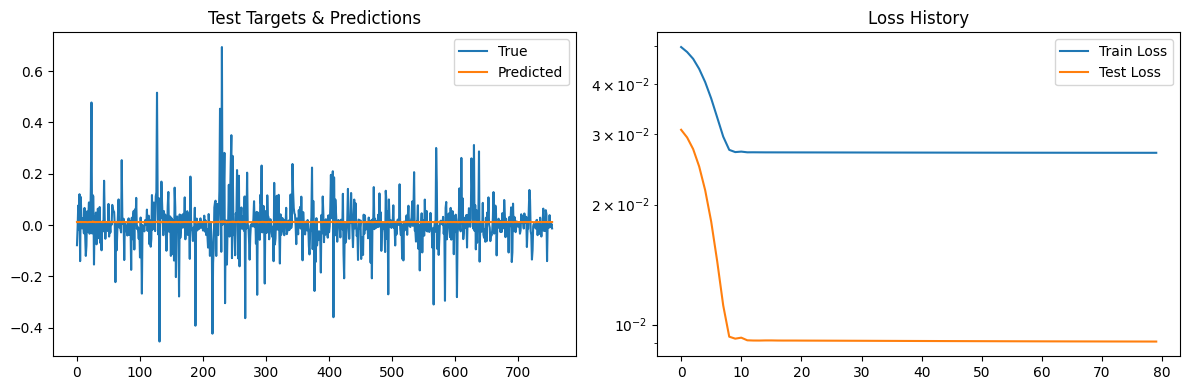

Epoch [800/50000], Train Loss: 0.02695385180413723, Test Loss: 0.00906726997345686, Epochs/sec: 24.45


KeyboardInterrupt: ignored

In [ ]:
torch.manual_seed(1)

# Initialize the model
net = Network(LSTM_INPUT_SIZE, LSTM_HIDDEN_SIZE, LSTM_LAYERS_N, DROPOUT_P)
net.apply(init_weights)
net = net.to(device)

# Specify loss function and optimizer
#optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE_ADAM, weight_decay=L2_WEIGHT_DECAY) # OK
#optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE_ADAGRAD, weight_decay=L2_WEIGHT_DECAY) # OK
#optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE_SGD, momentum=0.9, weight_decay=L2_WEIGHT_DECAY) # Wobbly
#optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE_RMS_PROP, weight_decay=L2_WEIGHT_DECAY) # OK
optimizer = optim.RAdam(net.parameters(), lr=LEARNING_RATE_RADAM, weight_decay=L2_WEIGHT_DECAY)
#optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE_ADAMW, weight_decay=L2_WEIGHT_DECAY)

# Create the learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

#loss_func = nn.L1Loss(reduction='mean')
loss_func = nn.MSELoss(reduction='mean')

# Track the loss history for both training and testing
loss_track = LossTracker()

lastDispUpdateTime = time.time()
lastDispUpdateEpoch = 0

updateLossHistStep = 10

# Training loop
for epoch in range(EPOCHS_N):

    train_preds = net(train_seqs)
    train_loss = loss_func(train_preds, train_targets.squeeze(-1))
    optimizer.zero_grad()

    # Optional L1 regularization
    if L1_REG_LAMBDA:
      l1_norm = sum(p.abs().sum() for p in net.parameters())
      loss = train_loss + L1_REG_LAMBDA * l1_norm
      loss.backward()
    else:
      train_loss.backward()

    # gradient clipping
    #torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)

    optimizer.step()

    # Step the scheduler
    #scheduler.step()

    isFirstOrLastEpoch = (epoch == 0 or epoch == (EPOCHS_N - 1))

    if isFirstOrLastEpoch or (epoch % updateLossHistStep) == 0:
        net.eval()  # Switch to evaluation mode
        with torch.no_grad():
            test_preds = net(test_seqs)
            test_loss = loss_func(test_preds, test_targets.squeeze(-1))

        loss_track.add_loss(train_loss.item(), test_loss.item())
        net.train()  # Switch back to training mode

    dispUpdateTime = time.time()
    if isFirstOrLastEpoch or ((epoch+1) % 100) == 0 and dispUpdateTime > (lastDispUpdateTime + 5.0):

        epochsPerSec = float(epoch - lastDispUpdateEpoch) / (dispUpdateTime - lastDispUpdateTime)
        lastDispUpdateTime = dispUpdateTime
        lastDispUpdateEpoch = epoch

        net.eval()  # Switch to evaluation mode
        test_preds_vec = []
        for i in range(len(test_seqs)):
            sequence = test_seqs[i].unsqueeze(0)
            pred = net(sequence).item()
            test_preds_vec.append(denormalizeVal(pred))

        # Clear previous plots
        clear_output(wait=True)

        # Create a figure
        fig, axs = plt.subplots(1, 2, figsize=(12,4))

        # Plot the targets and predictions
        axs[0].plot(test_targets.cpu().numpy(), label='True')
        axs[0].plot(test_preds_vec, label='Predicted')
        axs[0].set_title('Test Targets & Predictions')
        axs[0].legend()

        # Plot the loss history
        loss_track.plot_losses(axs[1])

        plt.tight_layout()
        plt.show()

        print(f"Epoch [{epoch+1}/{EPOCHS_N}], Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}, Epochs/sec: {epochsPerSec:.2f}")

        net.train()  # Switch back to training mode


In [ ]:
from google.colab import drive
drive.mount('/content/drive')